In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mannwhitneyu

%matplotlib inline
sns.set_palette(sns.color_palette("Set1", 2))
plt.rcParams["figure.figsize"] = (16,6)

## Read data

In [2]:
def parse_line(line):
    return [column.split("=")[1] for column in line.split("\t")]

with open("log.txt", "r") as log:
    lines = [line.strip() for line in log.readlines()]

rows = [parse_line(line) for line in lines if line]

In [3]:
data = pd.DataFrame(rows, columns=["slot", "user_id", "ts", "browser", "all_cl"])
data.loc[:, "all_cl"] = data.loc[:, "all_cl"].astype(int)

In [4]:
data.head()

,slot,user_id,ts,browser,all_cl
0,exp,1,2016-03-03,Browser #2,1
1,exp,1,2016-03-03,Browser #2,5
2,exp,1,2016-03-03,Browser #2,1
3,exp,1,2016-03-03,Browser #2,1
4,exp,1,2016-03-03,Browser #2,6


## Analysis

### Task 1

In [5]:
set(data.loc[data.slot == "exp", "user_id"].values) & set(data.loc[data.slot == "control", "user_id"].values)

set()

We have different users in "exp" and "control" groups.

In [6]:
def agg_clicks(data):
    return data.pivot_table(values="all_cl", columns="user_id", aggfunc=sum).values.squeeze()

def plot_hist(exp, control, title, max_value=50):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set(xlabel="clicks")
    sns.distplot(exp[exp <= max_value], label="exp", ax=ax)
    sns.distplot(control[control <= max_value], label="control", ax=ax)
    plt.legend()

In [7]:
exp_clicks = agg_clicks(data.loc[data.slot == "exp"])
control_clicks = agg_clicks(data.loc[data.slot == "control"])

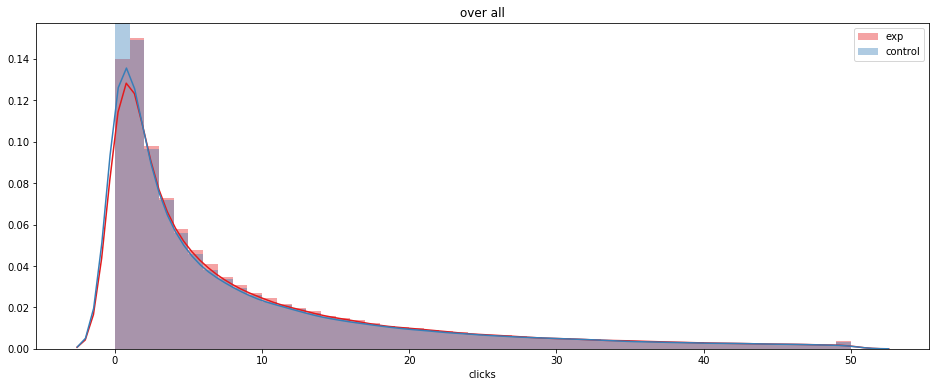

In [8]:
plot_hist(exp_clicks, control_clicks, "over all")

Let's use Mann–Whitney U test.

In [9]:
mannwhitneyu(exp_clicks, control_clicks)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

p-value is very small. <br>
This means that the experiment has an effect.

### Task 2

In [10]:
browsers = np.unique(data["browser"])

We have 6 different browsers. <br>
Let's analyze them separately.

In [11]:
browsers

array(['Browser #14', 'Browser #17', 'Browser #2', 'Browser #20',
       'Browser #22', 'Browser #4'], dtype=object)

In [12]:
def get_clicks_for_browser(data, browser):
    exp_browser = agg_clicks(data.loc[(data.slot == "exp") & (data.browser == browser)])
    control_browser = agg_clicks(data.loc[(data.slot == "control") & (data.browser == browser)])
    return exp_browser, control_browser

def analyse_browser(browser):
    exp_browser, control_browser = get_clicks_for_browser(data, browser)
    plot_hist(exp_browser, control_browser, browser)
    p_value = mannwhitneyu(exp_browser, control_browser).pvalue
    print("p-value = {p_value:0.4f}".format(p_value=p_value))

p-value = 0.0272


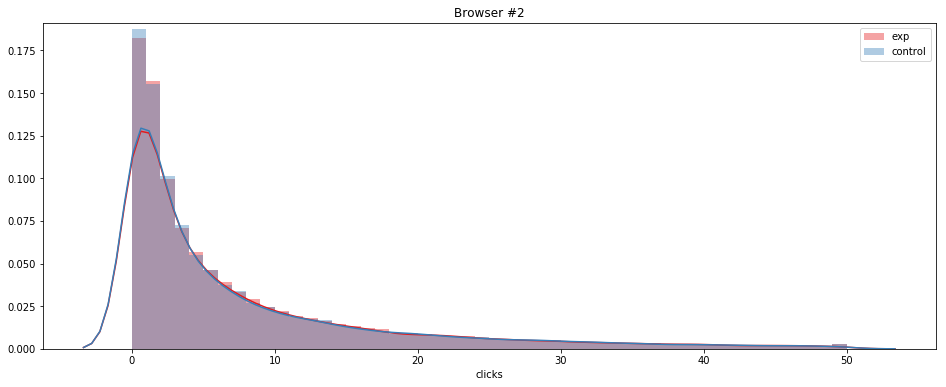

In [13]:
analyse_browser("Browser #2")

p-value = 0.4076


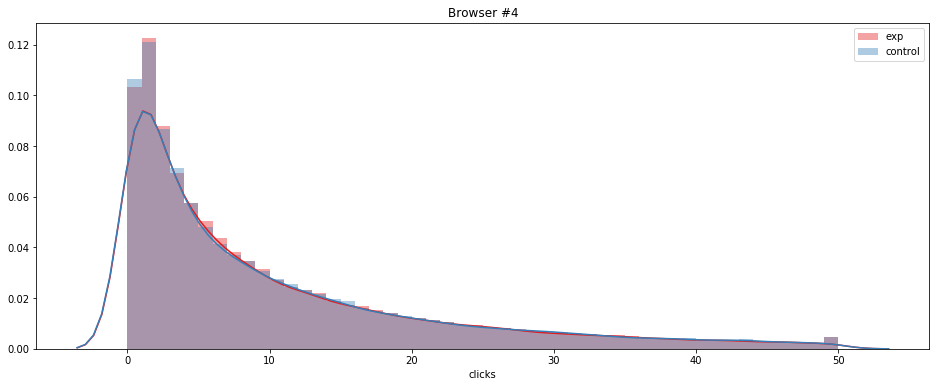

In [14]:
analyse_browser("Browser #4")

p-value = 0.0000


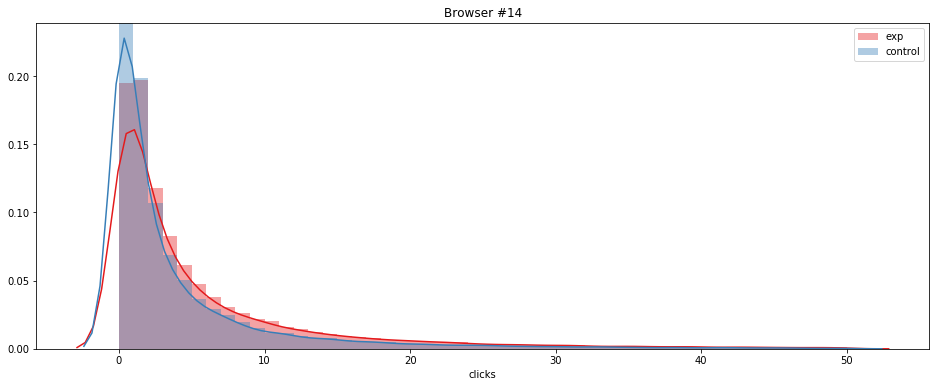

In [15]:
analyse_browser("Browser #14")

p-value = 0.0374


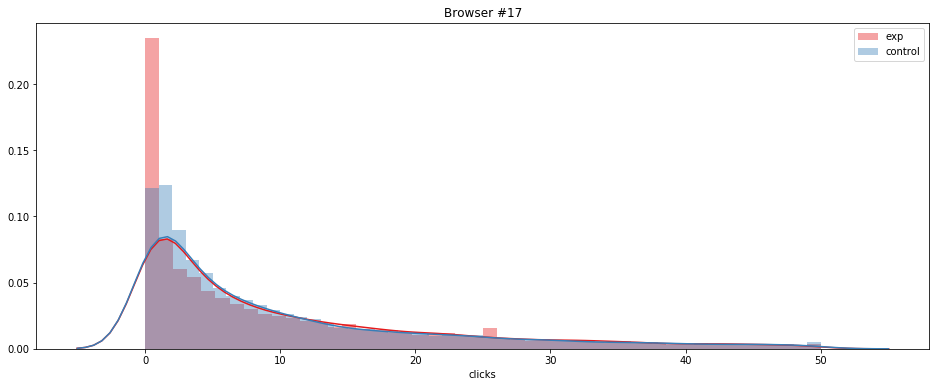

In [16]:
analyse_browser("Browser #17")

p-value = 0.4537


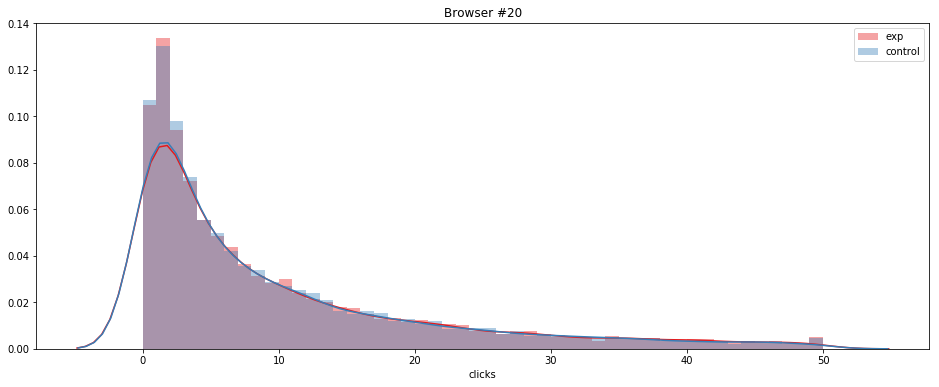

In [17]:
analyse_browser("Browser #20")

p-value = 0.2574


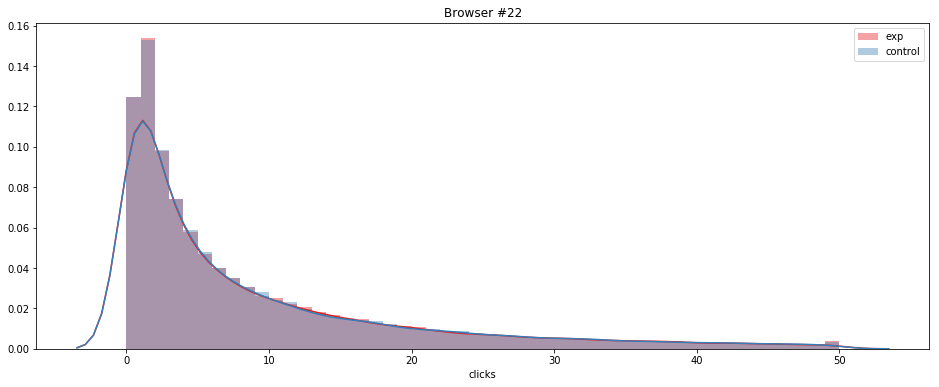

In [18]:
analyse_browser("Browser #22")

As we can see, Browser #14 has the smallest p-value. <br>
Browser #2 and Browser #17 have small p-values too. <br>
Other browsers have large p-values. <br>
Thus, we can conclude, that the experiment affected users of Browser #14 more than other users.

### Task 3

Unfortunately, without a context, we can not conclude anything about the positive or negative influence of the experiment.

On the one hand, more clicks -- it's good because people use the product more actively; on the other hand, perhaps people need to do more click to do things they want, and it's bad.

Here we analyzed the total count of clicks per user.
But we lost some information, which can be important. <br>
For example, 5 sessions with 1 click per session and 1 session with 5 clicks -- it is the same in our solution.
But actually, it is not.

Thus, we can conclude that the experiment has an effect, but we can not say anything about its positive or negative influence.